**Different definitions of mixed effects modeling**

I recently talked with Eric about mixed effects modeling. It reminded me about how what I had learned in Statistical Rethinking differs from other implementations such as what's described in [Linear Mixed-Effects Models Using R](https://link.springer.com/book/10.1007/978-1-4614-3900-4). That book references the `lme4` package which McElreath cites as a good non-Bayesian alternative. The main thing I wanted to understand is how my understanding of the Bayesian approach differs from common approaches that other statisticians might use. While putting this together, I came across TJ Mahr's great blog [post](https://www.tjmahr.com/plotting-partial-pooling-in-mixed-effects-models/) which I borrow heavily from references here.


In [1]:
from aesara import tensor as at   # needs to be fixed in repo
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

In [3]:
# Enable running of R code
%load_ext rpy2.ipython

In [4]:
%%R
suppressMessages(library(tidyverse))
suppressMessages(library(rethinking))
suppressMessages(library(lme4))
suppressMessages(library(arm))

In [5]:
df_sleep = pd.read_csv('/Users/blacar/Documents/ds_projects/stats_rethinking/data/b_other/sleep_lme4mahr.csv').drop('Unnamed: 0', axis=1)
df_sleep['Reaction_std'] = standardize(df_sleep['Reaction'])
df_sleep.head()

,Reaction,Days,Subject,Reaction_std
0,249.5600,0,308,-0.868751
1,258.7047,1,308,-0.705048
2,250.8006,2,308,-0.846543
3,321.4398,3,308,0.418000
4,356.8519,4,308,1.051927


# Visualize data

R[write to console]: `geom_smooth()` using formula 'y ~ x'



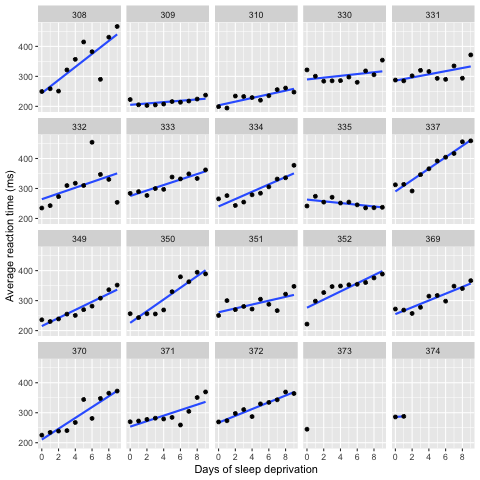

In [6]:
%%R -i df_sleep

# credit to TJ Mahr for this code
xlab <- "Days of sleep deprivation"
ylab <- "Average reaction time (ms)"

ggplot(df_sleep) + 
  aes(x = Days, y = Reaction) + 
  stat_smooth(method = "lm", se = FALSE) +
  # Put the points on top of lines
  geom_point() +
  facet_wrap("Subject") +
  labs(x = xlab, y = ylab) + 
  # We also need to help the x-axis, so it doesn't 
  # create gridlines/ticks on 2.5 days
  scale_x_continuous(breaks = 0:4 * 2)
#> `geom_smooth()` using formula 'y ~ x'

# Common definitions and examples of mixed effects modeling

The first equation has an explicit fixed effects term and varying effects term in the linear model (second line). The fixed and varying effects are the first and second parenthetical blocks, respectively.

In the second equation, the linear model is already "mixed". It contains both the fixed and varying effects terms implicitly. The fixed effects estimates can be seen in the third line.

**Equation form 1 (explicit fixed and varying effects terms in linear model)**

$$ R \sim \text{Normal}(\mu, \sigma) $$
$$ \mu = (\alpha + \beta \times d) + (\alpha_{[s]} + \beta_{[s]} \times d_{[s]}) $$

To run it in a Bayesian way, you can add this:
$$ \alpha \sim \text{Normal}(0, 1) $$
$$ \alpha_{[s]} \sim \text{Normal}(0, \sigma) $$
$$ \beta \sim \text{Normal}(0, 2) $$
$$ \beta_{[s]} \sim \text{Normal}(0, \sigma_{[s]}) $$
$$ \sigma \sim \text{Exp}(1) $$

**Equation form 2 (MVN, fixed effects as an adaptive prior)**

$$ R_i \sim \text{Normal}(\mu_i, \sigma) $$
$$ \mu_i = \alpha_{i} + \beta_{i} \times d_{i} $$
$$ \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\bar{\alpha} \\ \bar{\beta} \end{bmatrix} , \textbf{S} \right) $$
$$ \textbf{S} = \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} $$
$$ \bar{\alpha}, \bar{\beta} \sim \text{Normal}(0, 2) $$  
$$ \sigma_{\alpha}, \sigma_{\beta} \sim \text{Exp}(1) $$
$$ \textbf{R} \sim \text{LKJCorr}(2) $$

Let's run both equations.

# Equation form 1 (frequentist)

The `lmer` and by extension (`brms`) syntax was confusing to me. Thanks to @probot from the Discord channel for helping me understand this.

`lmer(Reaction ~ 1 + Days + (1 + Days | Subject), df_sleep)`

The `1` corresponds to inclusion of the intercept term. A `0` would exclude it. The `1 + Days` corresponds to the "fixed effects" portion of the model ($\alpha + \beta \times d$) while the `(1 + Days | Subject)` is the "varying effects" ($\alpha_{[s]} + \beta_{[s]} \times d_{[s]}$).

In [7]:
%%R -i df_sleep

# head(df_sleep)
m <- lmer(Reaction ~ 1 + Days + (1 + Days | Subject), df_sleep)
arm::display(m)

lmer(formula = Reaction ~ 1 + Days + (1 + Days | Subject), data = df_sleep)
            coef.est coef.se
(Intercept) 252.54     6.43 
Days         10.45     1.54 

Error terms:
 Groups   Name        Std.Dev. Corr 
 Subject  (Intercept) 24.14         
          Days         5.92    0.07 
 Residual             25.48         
---
number of obs: 183, groups: Subject, 20
AIC = 1783.4, DIC = 1787.8
deviance = 1779.6 


OK, now let's try the Bayesian approach and compare answers.

# Equation form 2 (Bayesian)

In [8]:
# reverse standardize intercept and slope
def reverse_standardize(x_std, df, vector):
    vector_mean, vector_std = df[vector].mean(), df[vector].std()
    x = (x_std*vector_std) + vector_mean
    return x

def reverse_standardize_slope(b_std, df, vector_y):
    # We'll only standardize the outcome variable (reaction time)
    # and leave the predictor variable (days) unstandardized
    vector_y_std = df[vector_y].std()
    b = b_std*vector_y_std
    return b


In [9]:
n_subjects = df_sleep['Subject'].nunique()
subject_idx = pd.Categorical(df_sleep["Subject"]).codes

with pm.Model() as mB:
    # can't specify a separate sigma_a and sigma_b for sd_dist but they're equivalent here
    chol, Rho_, sigma_cafe = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    # needs to be fixed in repo sd > sigma
    a_bar = pm.Normal("a_bar", mu=0, sigma=2.0)  # prior for average intercept
    b_bar = pm.Normal("b_bar", mu=0, sigma=2.0)  # prior for average slope

    # needs to be fixed in repo tt.stack > at.stack
    ab_subject = pm.MvNormal(
        "ab_subject", mu=at.stack([a_bar, b_bar]), chol=chol, shape=(n_subjects, 2)
    )  # population of varying effects
    # shape needs to be (n_subjects, 2) because we're getting back both a and b for each subject

    mu = ab_subject[subject_idx, 0] + ab_subject[subject_idx, 1] * df_sleep["Days"].values  # linear model
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within subjects (in the top line)

    rxn = pm.Normal("rxn", mu=mu, sigma=sigma_within, observed=df_sleep["Reaction_std"].values)  # likelihood

    idata_mB = pm.sample(1000, target_accept=0.9)


/Users/blacar/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
/Users/blacar/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your di

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 103 seconds.


In [10]:
# take a glimpse at the head and tail of the summary table
pd.concat(
    [
        az.summary(idata_mB).head(10),
        az.summary(idata_mB).tail(10)
    ]
)

/Users/blacar/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/blacar/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.811,0.126,-1.036,-0.569,0.002,0.002,3584.0,2772.0,1.0
b_bar,0.187,0.031,0.130,0.246,0.000,0.000,3968.0,3065.0,1.0
"ab_subject[0, 0]",-0.793,0.234,-1.223,-0.340,0.004,0.003,3818.0,2940.0,1.0
"ab_subject[0, 1]",0.352,0.044,0.271,0.437,0.001,0.001,3274.0,2934.0,1.0
"ab_subject[1, 0]",-1.530,0.235,-1.994,-1.107,0.004,0.003,2993.0,3093.0,1.0
"ab_subject[1, 1]",0.027,0.044,-0.059,0.106,0.001,0.001,2963.0,2781.0,1.0
"ab_subject[2, 0]",-1.508,0.237,-1.950,-1.056,0.004,0.003,3211.0,2832.0,1.0
"ab_subject[2, 1]",0.086,0.045,0.006,0.175,0.001,0.001,3537.0,3248.0,1.0
"ab_subject[3, 0]",-0.414,0.243,-0.861,0.055,0.005,0.003,2886.0,2543.0,1.0
"ab_subject[3, 1]",0.102,0.046,0.015,0.185,0.001,0.001,2783.0,2947.0,1.0


In [11]:
df_summary_int_and_slope = az.summary(idata_mB, var_names=['a_bar', 'b_bar'])
df_summary_int_and_slope

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.811,0.126,-1.036,-0.569,0.002,0.002,3584.0,2772.0,1.0
b_bar,0.187,0.031,0.130,0.246,0.000,0.000,3968.0,3065.0,1.0


The above values were after standardizing the response variable. The predictor variable (days) was left unchanged. Output the estimate on the natural scale.

In [12]:
 # put in dataframe for easy access/manipulation
 idata_mB_df = idata_mB.to_dataframe()

 # obtain all posterior values and reverse standardize
a_bar_natural_scale = list()
b_bar_natural_scale = list()
for a_bar, b_bar in zip(idata_mB_df[('posterior', 'a_bar')], idata_mB_df[('posterior', 'b_bar')]):
    a_bar_natural_scale.append(reverse_standardize(a_bar, df_sleep, 'Reaction'))
    b_bar_natural_scale.append(reverse_standardize_slope(b_bar, df_sleep, 'Reaction'))

print(f"intercept (mean): {np.mean(a_bar_natural_scale):0.2f}, (std): {np.std(a_bar_natural_scale):0.2f}")
print(f"    slope (mean): {np.mean(b_bar_natural_scale):0.2f}, (std): {np.std(b_bar_natural_scale):0.2f}")

intercept (mean): 252.65, (std): 7.04
    slope (mean): 10.49, (std): 1.74


As we can see, they are very close to the numbers with the first approach.


Frequentist output
```
  coef.est coef.se
(Intercept) 252.54     6.43 
Days         10.45     1.54 
```

Look at `pymc4.ipynb` for other ideas for plots.

# Acknowledgements

- Eric J. Daza about some discussions about mixed effects modeling. It reminded me about improving my knowledge in this area.
- Richard McElreath's Statistical Rethinking for my introduction to Bayesian multilevel modeling.
- Andrzej Gałecki and Tomasz Burzykowski's [Linear Mixed-Effecsts Models Using R](https://link.springer.com/book/10.1007/978-1-4614-3900-4) which references the `lme4` package. McElreath actually referenced this package as a non-Bayesian alternative in his book.
- Andrew Gelman wrote about why he doesn't like using "fixed and random effects" (in a [blog](https://statmodeling.stat.columbia.edu/2005/01/25/why_i_dont_use/) and in a [paper](https://projecteuclid.org/journals/annals-of-statistics/volume-33/issue-1/Analysis-of-variancewhy-it-is-more-important-than-ever/10.1214/009053604000001048.full)).
- TJ Mahr's [partial pooling blog post](https://www.tjmahr.com/plotting-partial-pooling-in-mixed-effects-models/).
- @probot from our Bayesian Discord channel.


In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl

Last updated: Tue Aug 23 2022

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.3.0

aesara: 2.7.9
aeppl : 0.0.27

matplotlib: 3.5.1
aesara    : 2.7.9
pymc      : 4.0.0b6
numpy     : 1.22.4
xarray    : 0.20.1
pandas    : 1.4.2
sys       : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:03:09) [Clang 13.0.1 ]
arviz     : 0.12.1

Watermark: 2.3.1

